# ISLR- Python Ch6 -- Lab 2: Ridge Regression and the Lasso

- [Load Hitters Dataset](#Load-Hitters-Dataset)
- [6.6.1 Ridge Regression](#6.6.1-Ridge-Regression)
    - [Plot Regression Coeffecients vs Ridge Penalty](#Plot-Regression-Coeffecients-vs-Ridge-Penalty)
    - [Use Validation And Cross Validation to Estimate Test MSE](#Use-Validation-And-Cross-Validation-to-Estimate-Test-MSE )
- [6.6.2 The Lasso](#6.6.2-The-Lasso)

In [132]:
# perform standard imports
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import scale
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Hitters Dataset

In [28]:
# In Lab 1 we explored the hitters dataframe locating rows with missing data and identifying
# categorical variables. See that lab for details...
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()

# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])

# Generate new dataframe with new dummy variables
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)

# add new dummy variables to hitters
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


## 6.6.1 Ridge Regression

In Ridge Regression, we seek to minimize an objective function of the form:

$\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2-\lambda\|\beta_j\|_2^2$. 

** R's GLMNET with $\bf{\alpha=0}$ minimizes the following:** (see https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html and https://core.ac.uk/download/files/153/6287975.pdf)

$\min \left(\frac{1}{2N}\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2-\frac{\lambda}{2}\|\beta_j\|_2^2\right)$

** SKLEARN.RIDGE minimizes:** (see http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

$\min \left(\sum_{i=1}^{N}{\left(y_i-\beta_0-\sum_{j=1}^{p}{\beta_jx_{i,j}}\right)}^2-\alpha\|\beta_j\|_2^2\right)$

From the above we can see that **glmnet uses the mean-squared error** and **sklearn minimizes the total squared error** To compare the two algorithms we would need to convert both lamdas and alphas to degrees of freedom (see Elements of Statistical Learning page 68). This involves computing the Singular Value Decomposition of the design matrix for hitters. The diagonal of this matrix has eigenvalues that determine the amount of shrikage for each predictor coeffecient. ** Upto this eigenvalue, sklearn's alpha is proportional to lambda/2N ** You can see this in the above equations by factoring out N. That is what we will do here. This will get us pretty close to glmnets coeffecients.

In [136]:
# Get the predictors and response from hitters
X = hitters.drop('Salary', axis = 1)
y = hitters.Salary

# list to hold our regression models
regr = []

# Make an array of alphas. To be consistent with R's sequence function, we must round the array to 
# integers see ( https://stat.ethz.ch/R-manual/R-devel/library/base/html/seq.html )
alphas = np.round(10**np.linspace(10,-2, 100))

# build models
for index, alph in enumerate(alphas):
    model = Ridge(alpha=alph/(2*len(hitters)), normalize=True, solver='cholesky')
    regr = np.append(regr, model.fit(X,y))

# show the alpha in sklearn and the corresponding lambda in glmnet
print('sklearn alpha =', regr[49].alpha, ' ~ glmnet lambda = ', regr[49].alpha*2*len(hitters),'\n')  

# make a datframe of the results
df = pd.Series(data = np.hstack([regr[49].intercept_, regr[49].coef_]), index=['Intercept'] + X.columns.tolist())

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha = 21.8593155894  ~ glmnet lambda =  11498.0 

Intercept      390.995767
AtBat            0.041618
Hits             0.156393
HmRun            0.588076
Runs             0.260564
RBI              0.270216
Walks            0.327651
Years            1.240153
CAtBat           0.003522
CHits            0.013128
CHmRun           0.098561
CRuns            0.026338
CRBI             0.027195
CWalks           0.028085
PutOuts          0.018871
Assists          0.002974
Errors          -0.025041
League_N         0.179969
Division_W      -7.167599
NewLeague_N      0.404737
dtype: float64 

l2 norm of Betas= 7.33089758943


In [116]:
# Now again for glmnet lambda 705
# show the alpha in sklearn and the corresponding lambda in glmnet
print('sklearn alpha =', regr[59].alpha, ' ~ glmnet lambda = ', regr[59].alpha*2*len(hitters),'\n')  

# make a datframe of the results
df = pd.Series(data = np.hstack([regr[59].intercept_, regr[59].coef_]), index=['Intercept'] + X.columns.tolist())

print(df,'\n')

print('l2 norm of Betas=', np.sqrt(sum(df.apply(lambda x: x**2).iloc[1:])))

sklearn alpha = 1.34030418251  ~ glmnet lambda =  705.0 

Intercept      43.108259
AtBat           0.108806
Hits            0.692836
HmRun           1.096093
Runs            0.967788
RBI             0.860277
Walks           1.382076
Years           2.439954
CAtBat          0.011041
CHits           0.048810
CHmRun          0.351217
CRuns           0.097512
CRBI            0.102103
CWalks          0.070079
PutOuts         0.127999
Assists         0.017948
Errors         -0.816414
League_N       15.301663
Division_W    -59.529078
NewLeague_N     9.049022
dtype: float64 

l2 norm of Betas= 62.2238235149


Notice the larger l2 norm when lambda is smaller (i.e. the coeffecient shrinkage is less).

## Plot Regression Coeffecients vs Ridge Penalty

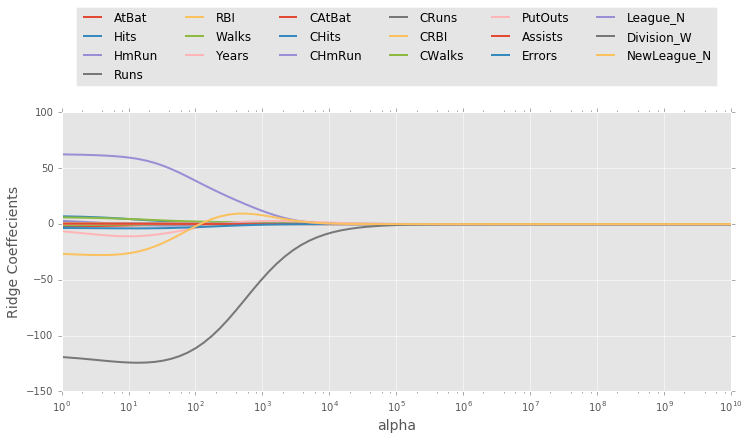

In [161]:
# We can make a plot of each of the ridge regression coeffecients as a function of the shrinkage factor alpha
ridge_coefs = np.empty((len(alphas),X.shape[1]))

# get standardized coeffs for each model
for index, model in enumerate(regr):
    ridge_coefs[index] = model.coef_[np.newaxis]
# Construct plot    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(alphas,ridge_coefs, linewidth =2.0);
ax.set_xscale('log')
ax.set_xlabel('alpha', fontsize=14)
ax.set_ylabel('Ridge Coeffecients', fontsize=14)
ax.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);

## Use Validation And Cross Validation to Estimate Test MSE